In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
competitions = sb.competitions()

In [4]:
help(sb.matches)

Help on function matches in module statsbombpy.sb:

matches(competition_id: int, season_id: int, fmt='dataframe', creds: dict = {'user': None, 'passwd': None})



In [5]:
# events = sb.competition_events(
#     country="England",
#     division= "Premier League",
#     season="2015/2016",
#     gender="male"
# )

In [6]:
#events.columns

In [7]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [8]:
#competitions[competitions['competition_name']=='Champions League']

In [9]:
SerieA = sb.matches(competition_id=12, season_id=27)
SerieA.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3879863,2016-05-08,15:00:00.000,Italy - Serie A,2015/2016,Atalanta,Udinese,1,1,available,...,None,37,Regular Season,Gewiss Stadium,Nicola Rizzoli,Edoardo Reja,Luigi De Canio,1.1.0,2,2
1,3879773,2016-03-06,16:00:00.000,Italy - Serie A,2015/2016,Frosinone,Udinese,2,0,available,...,None,28,Regular Season,Stadio Comunale Matusa,Nicola Rizzoli,Roberto Stellone,Stefano Colantuono,1.1.0,2,2
2,3879847,2016-04-30,18:00:00.000,Italy - Serie A,2015/2016,Udinese,Torino,1,5,available,...,None,36,Regular Season,Dacia Arena,Maurizio Mariani,Luigi De Canio,Gian Piero Ventura\t,1.1.0,2,2
3,3879862,2016-05-08,20:45:00.000,Italy - Serie A,2015/2016,Torino,Napoli,1,2,available,...,None,37,Regular Season,Stadio Olimpico Grande Torino,Antonio Damato,Gian Piero Ventura\t,Maurizio Sarri,1.1.0,2,2
4,3879817,2016-04-16,20:45:00.000,Italy - Serie A,2015/2016,Inter Milan,Napoli,2,0,available,...,None,33,Regular Season,Stadio Giuseppe Meazza,Gianluca Rocchi,Roberto Mancini,Maurizio Sarri,1.1.0,2,2


In [10]:
SerieA.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [11]:
print(pd.unique(SerieA['home_team']))

['Atalanta' 'Frosinone' 'Udinese' 'Torino' 'Inter Milan' 'Lazio' 'AS Roma'
 'Sassuolo' 'AC Milan' 'Sampdoria' 'Napoli' 'Juventus' 'Hellas Verona'
 'Bologna' 'Palermo' 'Fiorentina' 'Genoa' 'Empoli' 'Carpi' 'Chievo']


In [12]:
# elevations = {'King Power Stadium ': 57, 'The Hawthorns': 166, "St. James'' Park": 78, 'Goodison Park': 47,
#  'Selhurst Park': 54, 'Emirates Stadium': 31, 'White Hart Lane': 20, 'Stadium of Light': 40,
#  'Villa Park': 105, 'Anfield ': 66, 'bet365 Stadium': 131, 'Old Trafford':43,
#  'Vitality Stadium': 33,'Swansea.com Stadium': 15, "St. Mary''s Stadium": 1,
#  'Carrow Road': 7, 'Stamford Bridge':11, 'Vicarage Road':70, 'Etihad Stadium': 60,
#  'Boleyn Ground':11}

In [13]:
SerieA.iloc[0]

match_id                                    3879863
match_date                               2016-05-08
kick_off                               15:00:00.000
competition                         Italy - Serie A
season                                    2015/2016
home_team                                  Atalanta
away_team                                   Udinese
home_score                                        1
away_score                                        1
match_status                              available
match_status_360                        unscheduled
last_updated             2023-07-24T07:00:20.863653
last_updated_360                               None
match_week                                       37
competition_stage                    Regular Season
stadium                              Gewiss Stadium
referee                              Nicola Rizzoli
home_managers                          Edoardo Reja
away_managers                        Luigi De Canio
data_version

In [14]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [15]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome']

In [16]:
# check_attributes = ['pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
#        'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
#        'pass_inswinging', 'pass_length', 'pass_no_touch', 'pass_outcome',
#        'pass_outswinging', 'pass_recipient', 'pass_recipient_id',
#        'pass_shot_assist', 'pass_straight', 'pass_switch', 'pass_technique',
#        'pass_type', 'type', 'shot_outcome', 'location']
# first_match_df = pd.DataFrame(columns=check_attributes)
# for match in PremierLeague['match_id'][:1]:
#     match_df = sb.events(match_id=match)
#     relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
#     first_match_df = pd.concat([first_match_df, relevant_match_df], ignore_index=True)

# first_match_df['shot_outcome'] = first_match_df['shot_outcome'].replace(to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
#                'Saved to Post': 0, 'Saved Off Target': 0})

# first_match_df['distance'] = first_match_df.apply(lambda row: np.sqrt(np.abs(row.location[0]-120)**2 + 
#                                                      np.abs(row.location[1]-40)**2), axis=1)
# first_match_df

In [17]:
SerieA_shots_df = pd.DataFrame(columns=relevant_attributes)

In [18]:
start = time.time()
for match in SerieA['match_id']:#[:10]:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    SerieA_shots_df = pd.concat([SerieA_shots_df, relevant_match_df], ignore_index=True)

SerieA_shots_df['shot_outcome'] = SerieA_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

SerieA_shots_df['distance'] = SerieA_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
SerieA_shots_df['shot_angle'] = SerieA_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
SerieA_shots_df

script run time: 6.255302782853445 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,distance,shot_angle
0,9,30,Udinese,0.074454,Duván Esteban Zapata Banguera,Right Center Forward,"[112.0, 35.7]",Head,"[120.0, 36.7, 0.5]",NaN,Normal,Open Play,Shot,1,9.082401,0.493196
1,13,39,Atalanta,0.008508,Davide Brivio,Left Back,"[96.1, 19.5]",Left Foot,"[105.8, 29.0]",NaN,Normal,Open Play,Shot,0,31.487458,0.708971
2,15,14,Atalanta,0.085069,Marco Borriello,Center Forward,"[110.3, 41.2]",Head,"[118.6, 39.5, 1.4]",NaN,Normal,Open Play,Shot,0,9.773945,0.123086
3,18,36,Atalanta,0.783500,Gianpaolo Bellini,Right Back,"[108.1, 40.1]",Right Foot,"[120.0, 37.1, 1.2]",NaN,Normal,Penalty,Shot,1,11.900420,0.008403
4,19,31,Udinese,0.011791,Duván Esteban Zapata Banguera,Right Center Forward,"[110.5, 23.4]",Left Foot,"[120.0, 33.4, 6.2]",True,Half Volley,Open Play,Shot,0,19.126160,1.051002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,89,37,Lazio,0.030999,Danilo Cataldi,Center Defensive Midfield,"[98.6, 40.4]",Left Foot,"[99.8, 40.4]",NaN,Normal,Open Play,Shot,0,21.403738,0.018689
9994,90,22,Bologna,0.042634,Franco Brienza,Center Attacking Midfield,"[103.0, 51.3]",Left Foot,"[111.5, 44.2]",True,Normal,Open Play,Shot,0,20.412986,0.586644
9995,90,24,Bologna,0.038101,Franco Brienza,Center Attacking Midfield,"[103.8, 51.4]",Right Foot,"[109.6, 40.9]",True,Half Volley,Open Play,Shot,0,19.809089,0.613207
9996,90,25,Bologna,0.063746,Matteo Brighi,Right Center Midfield,"[110.0, 39.4]",Head,"[116.8, 40.9, 2.0]",NaN,Normal,Open Play,Shot,0,10.017984,0.059928


## Describing the Data

In [19]:
SerieA_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,9998.000000,9998.000000,9998.000000,9998.000000
mean,0.092096,0.095119,20.375004,0.467866
std,0.138325,0.293394,8.818727,0.315729
min,0.000180,0.000000,1.414214,0.000000
25%,0.024520,0.000000,13.024976,0.208056
50%,0.045155,0.000000,20.205445,0.431401
75%,0.089720,0.000000,26.820608,0.685084
max,0.966261,1.000000,88.833158,1.570796


In [20]:
SerieA_shots_df = SerieA_shots_df[SerieA_shots_df.shot_type != 'Corner']

In [21]:
SerieA_shots_df['shot_outcome'].value_counts()

shot_outcome
0    9046
1     950
Name: count, dtype: int64

In [22]:
SerieA_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg'])
for team in pd.unique(SerieA_shots_df['team']):
    shot_sum = SerieA_shots_df['team'].value_counts()[team]
    goal_sum = sum(SerieA_shots_df[SerieA_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(SerieA_shots_df[SerieA_shots_df['team']==team]['shot_statsbomb_xg'])
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum})
    SerieA_team_summary_df.loc[len(SerieA_team_summary_df)]=new_row
SerieA_team_summary_df = SerieA_team_summary_df.sort_values(by=['shots'], ascending=False)
SerieA_team_summary_df

,team,shots,goals,statsbomb_xg
4,Napoli,664,78,64.630668
15,Juventus,608,72,61.679564
9,AS Roma,592,83,61.949056
8,Fiorentina,582,58,53.828352
13,AC Milan,564,49,53.695526
5,Inter Milan,530,49,51.36453
6,Lazio,520,52,50.363241
10,Sassuolo,495,48,44.856433
2,Frosinone,492,34,31.477645
7,Empoli,489,39,36.909571


In [23]:
SerieA_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'distance',
       'shot_angle'],
      dtype='object')

## Training Model

In [24]:
cap_x_df, y_df = pd.concat([SerieA_shots_df.iloc[:,:-3], SerieA_shots_df.iloc[:,-2:]], axis=1),SerieA_shots_df.iloc[:,-3].to_frame()

In [25]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [26]:
target_attr = 'shot_outcome'

In [27]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [28]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'position']

In [29]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [30]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")),
               #('target_encoder', TargetEncoder(target_type=target_type, random_state=42)),
               ("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [31]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

## Try with Logistic Regression

In [32]:
estimator = LogisticRegression()

In [33]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [34]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', LogisticRegression())])

In [35]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.9097183 , 0.0902817 ],
       [0.9522353 , 0.0477647 ],
       [0.97240331, 0.02759669],
       ...,
       [0.98275262, 0.01724738],
       [0.9445129 , 0.0554871 ],
       [0.88084597, 0.11915403]])

In [36]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    7236
1     760
Name: count, dtype: int64
Training set naive model total xG 759.9989077673158
Training set Statsbomb total xG: 729.8124820783017


In [37]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [38]:
pd.unique(SerieA_shots_df['shot_type'])

array(['Open Play', 'Penalty', 'Free Kick'], dtype=object)

In [39]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [40]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1810
1     190
Name: count, dtype: int64
Test set naive model total xG 192.98543342401183
Statsbomb total xG: 190.96647685750017


In [41]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1810
1     190
Name: count, dtype: int64


In [42]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 190.96647685750017


In [43]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.07x+-0.01
$R^2$= 0.2434415515052789


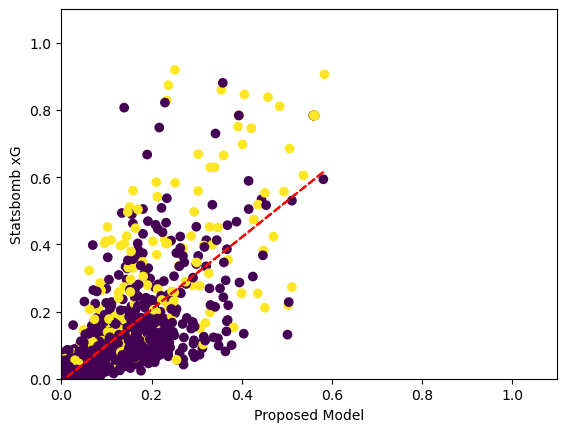

In [44]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [45]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,2000.0,190.0,190.966477,192.985433


## Try with SGDClassifier

In [46]:
estimator = SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=1000, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=None, 
        random_state=42, 
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=False, 
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=None, 
        warm_start=False, 
        average=False
    )

In [47]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [48]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

In [49]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.91063817, 0.08936183],
       [0.96367579, 0.03632421],
       [0.96791151, 0.03208849],
       ...,
       [0.99022187, 0.00977813],
       [0.95383067, 0.04616933],
       [0.93885546, 0.06114454]])

In [50]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    7236
1     760
Name: count, dtype: int64
Training set naive model total xG 575.9063269239585
Training set Statsbomb total xG: 729.8124820783017


In [51]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [52]:
pd.unique(SerieA_shots_df['shot_type'])

array(['Open Play', 'Penalty', 'Free Kick'], dtype=object)

In [53]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [54]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1810
1     190
Name: count, dtype: int64
Test set naive model total xG 146.44903512354807
Statsbomb total xG: 190.96647685750017


In [55]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1810
1     190
Name: count, dtype: int64


In [56]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 190.96647685750017


In [57]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.39x+-0.01
$R^2$= -0.39803187997565503


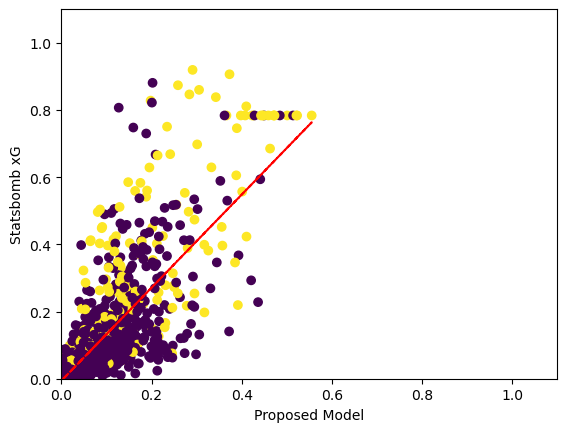

In [58]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [59]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,2000.0,190.0,190.966477,146.449035


## Try with RandomForest Classifier

In [60]:
estimator = RandomForestClassifier(
    n_estimators=500, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    max_leaf_nodes=16, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=42,
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [61]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [62]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [63]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.90494717, 0.09505283],
       [0.9457987 , 0.0542013 ],
       [0.94426301, 0.05573699],
       ...,
       [0.94697142, 0.05302858],
       [0.94666004, 0.05333996],
       [0.92056549, 0.07943451]])

In [64]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    7236
1     760
Name: count, dtype: int64
Training set naive model total xG 757.7200472878433
Training set Statsbomb total xG: 729.8124820783017


In [65]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [66]:
pd.unique(SerieA_shots_df['shot_type'])

array(['Open Play', 'Penalty', 'Free Kick'], dtype=object)

In [67]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [68]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1810
1     190
Name: count, dtype: int64
Test set naive model total xG 193.7561473826301
Statsbomb total xG: 190.96647685750017


In [69]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1810
1     190
Name: count, dtype: int64


In [70]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 190.96647685750017


In [71]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.23x+-0.02
$R^2$= 0.29914148897386283


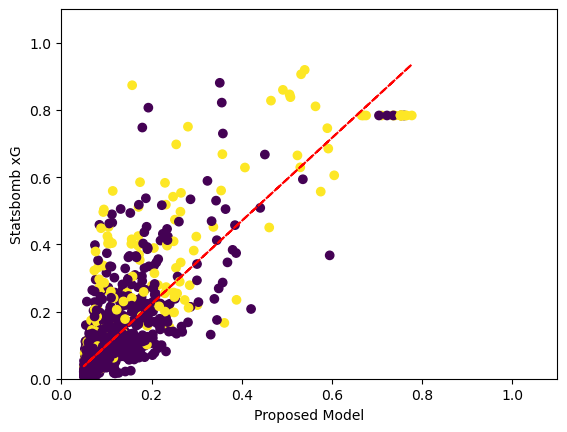

In [72]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [73]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,2000.0,190.0,190.966477,193.756147
